# Imports

## Environment Variables

In [21]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
ANTHROPIC_MODEL = os.getenv("ANTHROPIC_MODEL")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")

# Verify keys are loaded
print(f'Anthropic API Key loaded: {bool(os.getenv("ANTHROPIC_API_KEY"))}\nAnthropic model: {os.getenv("ANTHROPIC_MODEL")}')
print(f'OpenAI API Key loaded: {bool(os.getenv("OPENAI_API_KEY"))}\nOpenAI model: {os.getenv("OPENAI_MODEL")}')
print(OPENAI_MODEL)

Anthropic API Key loaded: True
Anthropic model: claude-sonnet-4-20250514
OpenAI API Key loaded: True
OpenAI model: gpt-4o-mini
gpt-4o-mini


## Packages

In [22]:
from typing import Literal, TypedDict
import json
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Configure LLM
&rarr; choose anthropic / openai 

In [23]:
def get_llm(provider: Literal["anthropic", "openai"] = "openai"):
    """Get LLM instance based on provider choice"""
    if provider == "anthropic":
        return ChatAnthropic(
            model=ANTHROPIC_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    elif provider == "openai":
        return ChatOpenAI(
            model=OPENAI_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    else:
        raise ValueError(f"Unknown provider: {provider}")

# Choose your provider here
LLM_PROVIDER = "openai"  # Change to "anthropic" if you prefer
llm = get_llm(LLM_PROVIDER)

print(f"Using {LLM_PROVIDER.upper()} as LLM provider")

Using OPENAI as LLM provider


# States 

In [24]:
# State = the data that flows through the workflow

class State(TypedDict):
    messages: list                  # Conversation history
    name: str                       # Employee name
    start_date: str                 # Start date
    end_date: str                   # End date (optional)
    work_hours: float               # Weekly work hours
    salary: float                   # Salary
    info_complete: bool             # All info collected?
    human_decision: str             # "approve" or "reject"
    is_update: bool                 # New entry or update existing?

# Nodes
NB: Chatbots are nodes

In [25]:
# System prompt for the chatbot
SYSTEM_PROMPT = """You are Lola, a friendly HR assistant collecting employee information.

You need to collect these fields (one at a time, conversationally):
1. name - Employee's full name
2. start_date - Employment start date (normalize to YYYY-MM-DD)
3. end_date - Employment end date, can be empty if ongoing (normalize to YYYY-MM-DD or "ongoing")
4. work_hours - Weekly work hours (as a number)
5. salary - Annual salary in CHF (as a number)


Important rules:
- Be friendly and conversational
- Ask for ONE piece of information at a time
- The user may answer in ANY date format or language (e.g. "1st of April 2026", "1. April 2026", German or English).
- You must ALWAYS normalize dates to ISO format: YYYY-MM-DD.
- If no end date exists, output null.
- End date must always be after beginning date, without exception and no matter how sure the user say they are
- Employee names must be properly capitalized: only the first letter of each word should be uppercase,
  and the rest lowercase. Examples:
  * "Zacharias HAeusgen" → "Zacharias Haeusgen"
  * "john SMITH" → "John Smith"
  * "MARIA garcia" → "Maria Garcia"
- Salary can be provided in any format (e.g., "50k EUR a year", "40K USD a year", "30k CHF a year"). 
- Salary MUST ALWAYS be a positive number
- You must ALWAYS convert the salary to CHF (Swiss Francs) as an annual integer amount.
- Use these approximate conversion rates: 1 EUR = 0.95 CHF, 1 USD = 0.88 CHF, 1 GBP = 1.12 CHF
- work hours must always be positive. maximum work hours allowed is 50 hours. if the user insists it is more, mention that it is not legal. do not accept negative values or values larger than 50.
- Ask follow-up questions only if information is missing or unclear.

When you have ALL the information, respond with ONLY a JSON object:
{"name": "...", "start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD or ongoing", "work_hours": number, "salary": number, "complete": true}

If information is still missing, just chat normally (no JSON).
"""

In [26]:
# Keywords to exit the conversation
EXIT_KEYWORDS = {"exit", "bye", "quit", "stop", "cancel", "goodbye", "end"}

In [27]:
# TODO add this programmatic data check? or leave just the LLM ?
def validate_data(data: dict) -> list[str]:
    """Validate collected data. Returns list of error messages."""
    errors = []
    
    # 1. Minimum yearly salary 20000 CHF
    salary = data.get("salary", 0)
    if salary < 20000:
        errors.append(f"Salary must be at least 20,000 CHF (got {salary})")
    
    # 2. Start date must be after 2010
    start_date = data.get("start_date", "")
    if start_date:
        start_year = int(start_date.split("-")[0])
        if start_year <= 2010:
            errors.append(f"Start date must be after 2010 (got {start_date})")
    
    # 3. End date must be after start date (if not ongoing)
    end_date = data.get("end_date", "")
    if end_date and end_date.lower() != "ongoing" and start_date:
        if end_date <= start_date:
            errors.append(f"End date ({end_date}) must be after start date ({start_date})")
    
    return errors

In [28]:
import re

def extract_json_from_text(text: str) -> dict | None:
    """Find and parse JSON object from text, even if surrounded by other content."""
    match = re.search(r'\{[^{}]*"complete"\s*:\s*true[^{}]*\}', text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return None
    return None

In [29]:
# NODE 1: Chatbot - collects employee info 

def chatbot_v2(state: State) -> dict:
    """
    NODE 1: Chatbot - collects employee info through conversation.
    
    Flow:
    1. Check for exit keywords -> cancel
    2. Call LLM with conversation history
    3. Check if response contains complete JSON
    4. If JSON found -> validate -> save or ask correction
    5. If no JSON -> continue conversation
    """
    messages = state.get("messages", [])
    
    # --- EXIT CHECK ---
    if messages and messages[-1]["role"] == "user":
        last_input = messages[-1]["content"].lower().strip()
        if last_input in EXIT_KEYWORDS:
            print("👋 Conversation ended by user.")
            return {"info_complete": True, "human_decision": "cancel"}
    
    # --- BUILD LLM MESSAGES ---
    llm_messages = [SystemMessage(content=SYSTEM_PROMPT)]
    
    for msg in messages:
        if msg["role"] == "user":
            llm_messages.append(HumanMessage(content=msg["content"]))
        elif msg["role"] == "assistant":
            llm_messages.append(AIMessage(content=msg["content"]))
        # skip system messages (like validation errors)
    
    # First message - greet user
    if not messages:
        llm_messages.append(HumanMessage(content="Hi, I need to do some human ressources stuff."))
    
    # --- CALL LLM ---
    response = llm.invoke(llm_messages)
    assistant_message = response.content
    print(f"🤖 Lola: {assistant_message}")
    
    # --- CHECK FOR COMPLETE JSON ---
    data = extract_json_from_text(assistant_message)
    
    if data and data.get("complete"):
        # --- VALIDATE DATA ---
        errors = validate_data(data)
        
        if errors:
            # Validation failed - show errors and ask for correction
            error_msg = "⚠️ Validation errors:\n" + "\n".join(f"  - {e}" for e in errors)
            print(error_msg)
            print("Please provide corrected values.")
            
            user_input = input("You: ")
            
            return {
                "messages": messages + [
                    {"role": "assistant", "content": assistant_message},
                    {"role": "assistant", "content": error_msg + " Please provide corrected values."},
                    {"role": "user", "content": user_input},
                ],
                "info_complete": False,
            }
        
        # Validation passed - save data to state
        print("✅ All information collected and validated!")
        return {
            "messages": messages + [{"role": "assistant", "content": assistant_message}],
            "name": data["name"],
            "start_date": data["start_date"],
            "end_date": data["end_date"],
            "work_hours": float(data["work_hours"]),
            "salary": float(data["salary"]),
            "info_complete": True,
        }
    
    # --- NO JSON YET - CONTINUE CONVERSATION ---
    user_input = input("You: ")
    
    return {
        "messages": messages + [
            {"role": "assistant", "content": assistant_message},
            {"role": "user", "content": user_input},
        ],
        "info_complete": False,
    }

In [30]:
# NODE 2: Human verification - asks for approval via input()
def human_verification(state: State) -> dict:
    """Shows collected data and asks human to approve or reject."""
    
    print("\n" + "="*50)
    print("📋 PLEASE REVIEW THE DATA:")
    print("="*50)
    print(f"   Name:       {state.get('name')}")
    print(f"   Start date: {state.get('start_date')}")
    print(f"   End date:   {state.get('end_date')}")
    print(f"   Work hours: {state.get('work_hours')}")
    print(f"   Salary:     {state.get('salary')} CHF")
    print("="*50)
    
    decision = input("Type 'approve' or 'reject': ").lower().strip()
    
    if decision == "approve":
        print("✅ Approved!")
        return {"human_decision": "approve"}
    else:
        print("❌ Rejected - returning to chatbot for corrections")
        return {"human_decision": "reject"}

In [31]:
# NODE 3: Create new entry
def create_entry(state: State) -> State:
    """Creates a new employee record"""
    
    # TODO: Add database insert logic here
    print(f"✅ [create_entry] Will create new entry for: {state.get('name')}")
    return state

In [32]:
# NODE 4: Update existing entry  
def update_entry(state: State) -> State:
    """Updates an existing employee record"""
    
    # TODO: Add database update logic here
    print(f"✅ [update_entry] Will update entry for: {state.get('name')}")
    return state

In [33]:
# ROUTER 1: After chatbot - keep collecting or go to verification?
def route_after_chatbot(state: State) -> str:
    # If cancelled, skip verification and end
    if state.get("human_decision") == "cancel":
        return END
    if state.get("info_complete"):
        return "human_verification"  # All info collected -> verify
    return "chatbot"                 # Missing info -> keep asking

In [34]:
# ROUTER 2: After human verification - what did human decide?
def route_after_verification(state: State) -> str:
    decision = state.get("human_decision")
    
    if decision == "reject":
        return "chatbot"             # Rejected -> go back to fix
    
    if decision == "approve":
        if state.get("is_update"):
            return "update_entry"    # Update existing
        return "create_entry"        # Create new
    
    return "chatbot"                 # No decision -> go back

# Workflow

In [35]:
# Build the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("chatbot", chatbot_v2)
workflow.add_node("human_verification", human_verification)
workflow.add_node("create_entry", create_entry)
workflow.add_node("update_entry", update_entry)

# Add edges (connections)
workflow.add_edge(START, "chatbot")                    # START -> chatbot

workflow.add_conditional_edges(                        # chatbot -> ? (depends on info_complete)
    "chatbot",
    route_after_chatbot,
    ["chatbot", "human_verification", END]             # Added END for cancel
)

workflow.add_conditional_edges(                        # human_verification -> ? (depends on decision)
    "human_verification", 
    route_after_verification,
    ["chatbot", "create_entry", "update_entry"]
)

workflow.add_edge("create_entry", END)                 # create_entry -> END
workflow.add_edge("update_entry", END)                 # update_entry -> END

In [36]:
# Compile the workflow (no interrupt - runs continuously)
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# Visualize graph

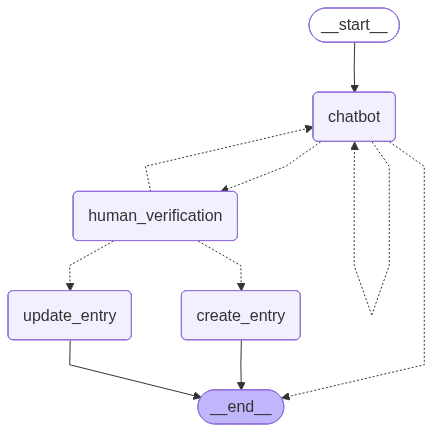

In [37]:
# Visualize the workflow
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

# Run the workflow

In [38]:
# Run the full workflow (all in one cell!)
initial_state = {
    "messages": [],
    "name": "",
    "start_date": "",
    "end_date": "",
    "work_hours": 0.0,
    "salary": 0.0,
    "info_complete": False,
    "human_decision": "",
    "is_update": False,
}

config = {"configurable": {"thread_id": "test-1"}}

# Run the entire workflow
for event in app.stream(initial_state, config):
    pass  # Output is printed by the nodes

print("\n🏁 Workflow complete!")

🤖 Lola: Hello! I'm here to help you with that. Let's start by getting some information. What's the full name of the employee?
🤖 Lola: Great! Just to make sure I have it right, I'll format the name properly. It will be "Morpheus Evangelcus." 

Now, could you please tell me the employment start date?
🤖 Lola: No problem at all! So the name will be "Morpheus Evangelicus." 

Now, could you please tell me the employment start date?
🤖 Lola: Thank you! I've noted the start date as February 4, 2026, which I'll format as 2026-02-04.

Next, can you provide the employment end date? If the employment is ongoing, just let me know!
🤖 Lola: Got it! I'll note that as ongoing.

Now, could you please tell me the weekly work hours?
🤖 Lola: It looks like 70 hours a week is more than the legal maximum of 50 hours. Could you please provide a number that is 50 or fewer?
🤖 Lola: Thank you! I've noted the weekly work hours as 45.

Lastly, could you please provide the annual salary? Feel free to use any currency